# Example ODE

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [84]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
from deepymod_torch.library_functions import library_1D_in

from scipy.optimize import least_squares
from scipy.sparse import coo_matrix

# Settings for reproducibility
np.random.seed(41)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

In [85]:
from __future__ import division
import numpy as np
from scipy.integrate import simps
from scipy.sparse import spdiags, coo_matrix, csc_matrix, dia_matrix, dok_matrix, identity
from scipy.sparse.linalg import spsolve
from itertools import chain
import pylab

import scipy


In [86]:
# Solves the nonlinear Fisher's equation implicit/explict discretisation 
# (Crank-Nicolson method) for the diffusion term and explicit for the
# reaction term using time stepping. Dirichlet BCs on l.h.s and r.h.s..
# 
# u_t = d u_{xx} + B u (1 - u)
#
# BUGS: Neumann boundary conditions on the r.h.s. do not work correctly
#       but provided we don't iterate the equation to forward in time
#       the analytical solution can be retrieved (because the boundary
#       point does not play a role in the solution).
#
#       The analytical experssion is only valid for DBCs on the l.h.s.
#       and NBCs on the r.h.s., but again let's not time step too far
#       so that we get good agreement.

def solution_fishers_eqn(x,t,d,B,n):
    """Analytical solution to Fishers equation with u(x0,t)=1
    and u_x(xJ,t)=0. The parameter n can be either 1 or 2."""
    if n == 1:
        U = 5 * np.sqrt(d * B / 6)
        return 1.0 / (1 + np.exp(np.sqrt(B/(6*d))*(x - U*t)) )**2
    elif n == 2:
        V = np.sqrt(d*B/2)
        return 1.0/ (1 + np.exp(np.sqrt(B/(2*d))*(x - V*t)) )
    else:
        raise ValueError("The parameter `n` must be an integer with the value 1 or 2.")

In [132]:
# Coefficients and simulation constants
x = np.linspace(-10, 10, 100)
x_range = np.max(x) - np.min(x)
h = x_range / len(x)
d = 0.5
B = 0.250
s = d / h**2
tau = 0.5
fsn = 1

# Initial conditions (needs to end up as a column vector)
u_init = np.matrix( solution_fishers_eqn(x,0.0,d,B,fsn) ).reshape((len(x),1))
u = u_init

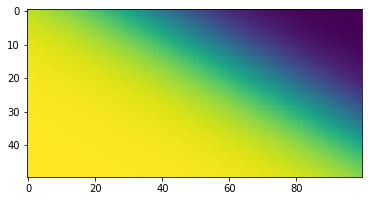

In [133]:
solution_plot = np.array([solution_fishers_eqn(x, i*tau, d, B, fsn) for i in np.arange(0,n_t)])
plt.imshow(solution_plot)

In [134]:
solution = np.array([solution_fishers_eqn(x, i*tau, d, B, fsn) for i in np.arange(0,n_t)]).reshape((-1,1))

In [135]:
n_t = 50

In [136]:
x_input = np.array([x for i in np.arange(0,n_t)])
t_input = np.array([i*tau*np.ones(x.shape) for i in np.arange(0,n_t)])

In [137]:
X_input = np.vstack((t_input.flatten(),x_input.flatten())).T

Let's plot it to get an idea of the data:

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [138]:
np.max(np.abs(X_input),axis=0)

array([24.5, 10. ])

In [139]:
X_input.shape

(5000, 2)

In [140]:
solution.shape

(5000, 1)

In [141]:
X_rs = X_input
Y_rs = solution # /np.max(np.abs(Y),axis=0)

In [144]:
number_of_samples = 800

idx = np.random.permutation(Y_rs.shape[0])
X_train = torch.tensor(X_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [145]:
print(X_train.shape, y_train.shape)

torch.Size([800, 2]) torch.Size([800, 1])


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [146]:
## Running DeepMoD
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20, 20, 20], 'n_out': 1, 'library_function': library_1D_in, 'library_args':{'poly_order': 2, 'diff_order': 2}}

Now we instantiate the model:

In [147]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [148]:
train_deepmod(model, X_train, y_train, optimizer, 50000, {'l1': 1e-6})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       9500     19.00%            1071s   1.84e-06   7.27e-07   1.01e-07   1.01e-06 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [11]:
solution = model(X_train)[0].detach().numpy()

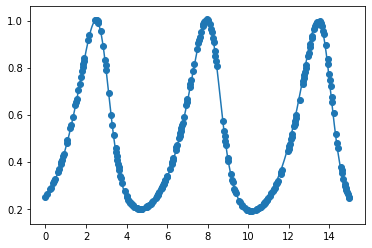

In [12]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,0])
plt.plot(T_rs,Y_rs[:,0])

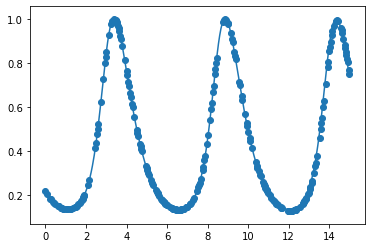

In [13]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,1])
plt.plot(T_rs,Y_rs[:,1])